In [2]:
import re

original = "../../datasets/doggy_data/test_ft_output_1000"

with open(original, 'r') as file:
    lines = file.readlines()
    tags = []
    for line in lines:
        match = re.search(r'<([^>]+)>', line)
        if match:
            tags.append(match.group(1))

print(set(tags))



{'light_kappa', 'heavy', 'light_lambda'}


Max Loss Sequence:
Target: IVMTQTPLSLSVSPGETASISCKEDSNGNTHLHWFRQKSGQSPQGLIYEVSNRDPGVPDRFSGSGSGTDFTLRISRVEADDAGVYYCMQGMPGLPTFGQGTKLEIK
Aligned: EVVMMMMMMMMMMGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGPGPGPGPGPGPGPGPGPGPGPGPGPGPGPGPGPGPGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGSGGGGGG
Average Alignment Loss: 80.693
Average Alignment Loss for Light Kappa: 67.09895833333333
Average Alignment Loss for Light Lambda: 115.24175824175825
Average Alignment Loss for Heavy: 74.81789137380191


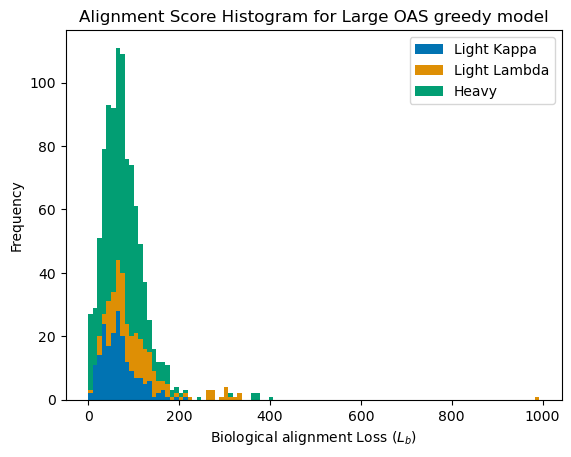

In [3]:
from Bio import Align
from Bio.Align import substitution_matrices
import pandas as pd
import seaborn as sns

aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.open_gap_score = -11
aligner.extend_gap_score = -1
aligner.substitution_matrix = substitution_matrices.load(name='PAM30')

# aligner.open_gap_score = -1
# aligner.extend_gap_score = -1

alignment_scores = []
alignment_targets = []
alignment_losses = []

import matplotlib.pyplot as plt

# with open('../../datasets/outputs/small_ft_full_beam/test/processed', 'r') as file:
#     pairs = file.read().split('\n\n')
#     for pair in pairs:
#         seqs = pair.split('\n')
#         if len(seqs) < 2:
#             continue
#         alignment = aligner.align(seqs[0].strip("target: "), seqs[1])
#         alignment_target = aligner.align(seqs[0].strip("target: "), seqs[0].strip("target: "))
#         alignment_scores.append(alignment.score)
#         alignment_targets.append(alignment_target.score)
#         alignment_losses.append(alignment_target.score - alignment.score)

# average_score = sum(alignment_losses) / len(alignment_scores)
# print("Average Alignment Score:", average_score)

# df = pd.DataFrame({'losses': alignment_losses, 'tags': tags})

# df_light_kappa = df[df['tags'] == 'light_kappa']
# df_heavy = df[df['tags'] == 'heavy']

# plt.hist(df_light_kappa['losses'], bins=100, color='red', label='Light Kappa')
# plt.hist(df_heavy['losses'], bins=100, color='blue', label='Heavy')
# plt.xlabel('Alignment Loss')
# plt.ylabel('Frequency')
# plt.title('Alignment Score Histogram (Beam Pretrained on OAS)')
# plt.legend()
# plt.show()

# alignment_scores = []
# alignment_targets = []
# alignment_losses = []
# with open('../../datasets/outputs/small_ft_beam/test/processed', 'r') as file:
#     pairs = file.read().split('\n\n')
#     for pair in pairs:
#         seqs = pair.split('\n')
#         if len(seqs) < 2:
#             continue
#         alignment = aligner.align(seqs[0].strip("target: "), seqs[1])
#         alignment_target = aligner.align(seqs[0].strip("target: "), seqs[0].strip("target: "))
#         alignment_scores.append(alignment.score)
#         alignment_targets.append(alignment_target.score)
#         alignment_losses.append(alignment_target.score - alignment.score)

# average_score = sum(alignment_losses) / len(alignment_scores)
# print("Average Alignment Score:", average_score)

# df = pd.DataFrame({'losses': alignment_losses, 'tags': tags})

# df_light_kappa = df[df['tags'] == 'light_kappa']
# df_heavy = df[df['tags'] == 'heavy']

# plt.hist(df_light_kappa['losses'], bins=100, color='red', label='Light Kappa')
# plt.hist(df_heavy['losses'], bins=100, color='blue', label='Heavy')
# plt.xlabel('Alignment Loss')
# plt.ylabel('Frequency')
# plt.title('Alignment Score Histogram (Beam Pretrained on canine)')
# plt.legend()
# plt.show()

alignment_scores = []
alignment_targets = []
alignment_losses = []
with open('../../sample_outputs/2024_10_05__18_18_59/t5_baseline_base_ft_full_greedy_samples_processed', 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 3):
        alignment_target = aligner.align(lines[i].strip("target: ").strip(), lines[i].strip("target: ").strip())
        alignment_targets.append(alignment_target.score)
        if len(lines[i+1].strip()) == 0:
            alignment_scores.append(0)
            alignment_losses.append(alignment_target.score)
            continue
        alignment = aligner.align(lines[i].strip("target: ").strip(), lines[i+1].strip())
        alignment_scores.append(alignment.score)
        alignment_losses.append(alignment_target.score - alignment.score)

max_loss_index = alignment_losses.index(max(alignment_losses))
print(f"Max Loss Sequence:\nTarget: {lines[max_loss_index * 3].strip()}\nAligned: {lines[max_loss_index * 3 + 1].strip()}")

# BEGIN: Remove sequence with the highest loss
# alignment_scores.pop(max_loss_index)
# alignment_targets.pop(max_loss_index)
# alignment_losses.pop(max_loss_index)
# tags.pop(max_loss_index)
# END: Remove sequence with the highest loss
average_score = sum(alignment_losses) / len(alignment_scores)
print("Average Alignment Loss:", average_score)

df = pd.DataFrame({'losses': alignment_losses, 'tags': tags})

df_light_kappa = df[df['tags'] == 'light_kappa']['losses']
df_light_lambda = df[df['tags'] == 'light_lambda']['losses']
df_heavy = df[df['tags'] == 'heavy']['losses']

avg_light_kappa = df_light_kappa.mean()
avg_light_lambda = df_light_lambda.mean()
avg_heavy = df_heavy.mean()

print(f"Average Alignment Loss for Light Kappa: {avg_light_kappa}")
print(f"Average Alignment Loss for Light Lambda: {avg_light_lambda}")
print(f"Average Alignment Loss for Heavy: {avg_heavy}")

colors = sns.color_palette("colorblind", 3)
labels = ['Light Kappa', 'Light Lambda', 'Heavy']

plt.hist([df_light_kappa, df_light_lambda, df_heavy], bins=100, color=colors, label=labels, histtype='barstacked')
plt.xlabel('Biological alignment Loss $(L_b)$')
plt.ylabel('Frequency')
plt.title('Alignment Score Histogram for Large OAS greedy model')
plt.legend()
plt.savefig("histogram.pdf", format="pdf", bbox_inches="tight")



In [9]:
from Bio import Align
from Bio.Align import substitution_matrices
import pandas as pd
import seaborn as sns
import numpy as np

aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.open_gap_score = -11
aligner.extend_gap_score = -1
aligner.substitution_matrix = substitution_matrices.load(name='PAM30')

alignment_scores = []
alignment_targets = []
alignment_losses = []

with open('../../sample_outputs/2024_10_05__18_18_59/t5_baseline_base_ft_full_greedy_samples_processed', 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 3):
        alignment_target = aligner.align(lines[i].strip("target: ").strip(), lines[i].strip("target: ").strip())
        alignment_targets.append(alignment_target.score)
        if len(lines[i+1].strip()) == 0:
            alignment_scores.append(0)
            alignment_losses.append(alignment_target.score)
            continue
        alignment = aligner.align(lines[i].strip("target: ").strip(), lines[i+1].strip())
        alignment_scores.append(alignment.score)
        alignment_losses.append(alignment_target.score - alignment.score)

best_alignment_index = alignment_losses.index(min(alignment_losses))
worst_alignment_index = alignment_losses.index(max(alignment_losses))
second_worst_alignment_index = sorted(range(len(alignment_losses)), key=lambda i: alignment_losses[i], reverse=True)[1]

print(f"Best Alignment Index: {best_alignment_index}, Value: {alignment_losses[best_alignment_index]}")
print(f"Worst Alignment Index: {second_worst_alignment_index}, Value: {alignment_losses[second_worst_alignment_index]}")

median_score = np.median(alignment_losses)
print(f"Median Alignment Score: {median_score}")
closest_to_median_index = min(range(len(alignment_losses)), key=lambda i: abs(alignment_losses[i] - median_score))
print(f"Index of Alignment Closest to Median: {closest_to_median_index}, Value: {alignment_losses[closest_to_median_index]}")

average_score = np.mean(alignment_losses)
print(f"Average Alignment Score: {average_score}")
closest_to_average_index = min(range(len(alignment_losses)), key=lambda i: abs(alignment_losses[i] - average_score))
print(f"Index of Alignment Closest to Average: {closest_to_average_index}, Value: {alignment_losses[closest_to_average_index]}")

print(f"Best Alignment Sequence:\nTarget: {lines[best_alignment_index * 3].strip()}\nAligned: {lines[best_alignment_index * 3 + 1].strip()}")
print(f"Worst Alignment Sequence:\nTarget: {lines[second_worst_alignment_index * 3].strip()}\nAligned: {lines[second_worst_alignment_index * 3 + 1].strip()}")
worst_alignment_natural = lines[second_worst_alignment_index * 3].strip()
worst_alignment_de_novo = lines[second_worst_alignment_index * 3 + 1].strip()
print(f"Most Median Alignment Sequence:\nTarget: {lines[closest_to_median_index * 3].strip()}\nAligned: {lines[closest_to_median_index * 3 + 1].strip()}")
median_alignment_natural = lines[closest_to_median_index * 3].strip()
median_alignment_de_novo = lines[closest_to_median_index * 3 + 1].strip()
print(f"Most Average Alignment Sequence:\nTarget: {lines[closest_to_average_index * 3].strip()}\nAligned: {lines[closest_to_average_index * 3 + 1].strip()}")
average_alignment_natural = lines[closest_to_average_index * 3].strip()
average_alignment_de_novo = lines[closest_to_average_index * 3 + 1].strip()

Best Alignment Index: 126, Value: 0.0
Worst Alignment Index: 369, Value: 404.0
Median Alignment Score: 71.0
Index of Alignment Closest to Median: 1, Value: 71.0
Average Alignment Score: 80.693
Index of Alignment Closest to Average: 34, Value: 81.0
Best Alignment Sequence:
Target: EGQLAESGGDLVKPGGSLRLSCVASGFTFSSYGMSWVRQSPGKGLQWVAAISSSGSSTYYADAVKGRFTISRDNAKNTLYLQMNSLRAEDTAVYYCAKDLLSLVAAGTLDFDYWGQGTLVTVSS
Aligned: EGQLAESGGDLVKPGGSLRLSCVASGFTFSSYGMSWVRQSPGKGLQWVAAISSSGSSTYYADAVKGRFTISRDNAKNTLYLQMNSLRAEDTAVYYCAKDLLSLVAAGTLDFDYWGQGTLVTVSS
Worst Alignment Sequence:
Target: ELTLQESGPGLVKPSQTLSLTCVVSGGSLTSSYYWNWIRQRPGRGLEWMGYWTGITNYNPAFQGRISITADTARNQFSLHLTSMTTEDTGVYYCLRERFYGSPDYWGQGTLVTVSS
Aligned: ELQLVESGGDLVKPGGSLRLSCVASGGSLTSSYYMYWVRQSPGKGLQWVAYWTGITNYADAVKGRFTISRDNAKNTLYLQMNSLRAEDTAVYYCLRERFYGSPDYWGQGTLVTVSS
Most Median Alignment Sequence:
Target: EGQLAESGGDLVKPAGSLRLSCVASGFTFSIYSMSWVRQAPEKGLQLVAGIDSGGRNTYYTDAVKGRFTISRDNAKNTVYLQMNSLRAEDTAMYYCAKDLVATDGGEYWGQGTLVTVSS
Aligned: EGQLAESGGDLVKP

In [10]:
import requests

class annotate():
    """
    class `annotate`. 
    
    Initiator `__init__` has 2 parameters:
    
    :param aaseq: STRING: A single-letter, amino acid sequence corresponding to the complete VH or VL chain. Both uppercase and lowercase are accepted. 
    
    :param scheme: STRING: "kabat", "chothia", "contact", or "imgt". Must be in lowercase
    
    Class has 3 methods. `retrieve()`: retrieves numbered seqs from Abnum website, then sends it to method `analyze` to determine the FR and CDR regions, and to `output() ` to print the result and return a list of 2 dictionaries, the first of which contains to region:seq pairs, the second of which contains number:residue pairs. 
    
    """
    
    def __init__(self, aaseq, scheme):
        
        self.aaseq=aaseq
        self.scheme=scheme
    
    def __repr__(self):
        return "Annotation of VH or VL sequence using Kabat, Chothia, Contact, or IMGT scheme"
    
    def output(self, chain, lst, regionlst):
        """
        Prints the FR and CDR regions and their corresponding seq. It returns a `list` of 2 `dict`. 
        
        :param chain: STRING, either "H" or "L" in uppercase
        :param lst:  LIST, a list of residue and their corresponding numbers in kabat or chothia scheme
        :param regionlst: LIST, a list of peptides, each corresponds to a FR or CDR region
        :return: LIST, a list of 2 `dict`, The first dict consists of region: seq pairs. The second dict consists of number:residue pairs.
        
        """
        
        self.chain=chain
        self.lst=lst
        self.regionlst=regionlst

        self.regiondict, self.numberdict={}, {}
        
        for i in range (0, len(self.lst), 2):
            self.numberdict[self.lst[i]]=self.lst[i+1]
        
        
        if self.scheme=="kabat":
            print("Annotation in Kabat scheme:")
        elif self.scheme=="chothia":
            print("Annotation in Chothia scheme:")
        elif self.scheme=="contact":
            print("Annotation in Contact scheme:")
        else:
            print("Annotation in IMGT scheme:")
        
        if self.chain=="L":
            print("L-FR1:  ", self.regionlst[0])
            print("L-CDR1: ", self.regionlst[1])
            print("L-FR2:  ", self.regionlst[2])
            print("L-CDR2: ", self.regionlst[3])
            print("L-FR3:  ", self.regionlst[4])
            print("L-CDR3: ", self.regionlst[5])
            print("L-FR4:  ", self.regionlst[6])
            
            for region, seq in zip(["L-FR1", "L-CDR1", "L-FR2","L-CDR2", "L-FR3", "L-CDR3", "L-FR4"], self.regionlst):
                self.regiondict[region]=seq
            
            return [self.regiondict, self.numberdict]
                
        else:
            print("H-FR1:  ", self.regionlst[0])
            print("H-CDR1: ", self.regionlst[1])
            print("H-FR2:  ", self.regionlst[2])
            print("H-CDR2: ", self.regionlst[3])
            print("H-FR3:  ", self.regionlst[4])
            print("H-CDR3: ", self.regionlst[5])
            print("H-FR4:  ", self.regionlst[6])
            
            for region, seq in zip(["H-FR1", "H-CDR1", "H-FR2","H-CDR2", "H-FR3", "H-CDR3", "H-FR4"], self.regionlst):
                self.regiondict[region]=seq
            
            return [self.regiondict, self.numberdict]
            
        
        
        

    
    def analyze(self,chain, lst):
        """
        Define CDR and FR regions based on the numbered sequence returned from website
        
        :param chain: STRING, "H" or "L" in uppercase
        :param lst: LIST, a list of residue and their corresponding numbers in kabat or chothia scheme
        :return: LIST, a list of strings, where each string is a peptide corresponding to the a region, in the order of: FR1, CDR1, FR2, CDR2, FR3, CDR3, FR4
        
        :raises: `ValueError` if any of the FR or CDR region is missing
        
        """
        
        self.chain=chain
        self.lst=lst
        if self.chain=="L":
            self.L_FR1, self.L_CDR1, self.L_FR2, self.L_CDR2, self.L_FR3, self.L_CDR3, self.L_FR4=["" for i in range (0, 7)]
            
            try:
                if self.scheme in ["kabat", "chothia"]:
                    self.L_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("L24"), 2)])
                    self.L_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("L24"), self.lst.index("L35"), 2)])
                    self.L_FR2="".join([self.lst[i+1] for i in range (self.lst.index("L35"), self.lst.index("L50"), 2)])
                    self.L_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("L50"), self.lst.index("L57"), 2)])
                    self.L_FR3="".join([self.lst[i+1] for i in range (self.lst.index("L57"), self.lst.index("L89"), 2)])
                    self.L_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("L89"), self.lst.index("L98"), 2)])
                    self.L_FR4="".join([self.lst[i+1] for i in range (self.lst.index("L98"), len(self.lst), 2)])
                                    
                elif self.scheme =="contact": 
                    self.L_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("L30"), 2)])
                    self.L_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("L30"), self.lst.index("L37"), 2)])
                    self.L_FR2="".join([self.lst[i+1] for i in range (self.lst.index("L37"), self.lst.index("L46"), 2)])
                    self.L_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("L46"), self.lst.index("L56"), 2)])
                    self.L_FR3="".join([self.lst[i+1] for i in range (self.lst.index("L56"), self.lst.index("L89"), 2)])
                    self.L_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("L89"), self.lst.index("L97"), 2)])
                    self.L_FR4="".join([self.lst[i+1] for i in range (self.lst.index("L97"), len(self.lst), 2)])
                                    
                else: #IMGT scheme
                    self.L_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("L27"), 2)])
                    self.L_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("L27"), self.lst.index("L33"), 2)])
                    self.L_FR2="".join([self.lst[i+1] for i in range (self.lst.index("L33"), self.lst.index("L50"), 2)])
                    self.L_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("L50"), self.lst.index("L52"), 2)])
                    self.L_FR3="".join([self.lst[i+1] for i in range (self.lst.index("L52"), self.lst.index("L89"), 2)])
                    self.L_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("L89"), self.lst.index("L98"), 2)])
                    self.L_FR4="".join([self.lst[i+1] for i in range (self.lst.index("L98"), len(self.lst), 2)])
                
                return [self.L_FR1, self.L_CDR1, self.L_FR2, self.L_CDR2, self.L_FR3, self.L_CDR3, self.L_FR4] 

            except ValueError:
                print("Unable to retrieve complete V region. Make sure the sequence has complete V region")
            except:
                print("An error occured")
        else:
            self.H_FR1, self.H_CDR1, self.H_FR2, self.H_CDR2, self.H_FR3, self.H_CDR3, self.H_FR4=["" for i in range (0, 7)]
            try:
                if self.scheme=="kabat":
                    self.H_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("H31"), 2)])
                    self.H_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("H31"), self.lst.index("H36"), 2)])
                    self.H_FR2="".join([self.lst[i+1] for i in range (self.lst.index("H36"), self.lst.index("H50"), 2)])
                    self.H_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("H50"), self.lst.index("H66"), 2)])
                    self.H_FR3="".join([self.lst[i+1] for i in range (self.lst.index("H66"), self.lst.index("H95"), 2)])
                    self.H_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("H95"), self.lst.index("H103"), 2)])
                    self.H_FR4="".join([self.lst[i+1] for i in range (self.lst.index("H103"), len(self.lst), 2)])            
            
                elif self.scheme=="chothia":
                    self.H_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("H26"), 2)])
                    self.H_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("H26"), self.lst.index("H33"), 2)])
                    self.H_FR2="".join([self.lst[i+1] for i in range (self.lst.index("H33"), self.lst.index("H52"), 2)])
                    self.H_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("H52"), self.lst.index("H57"), 2)])
                    self.H_FR3="".join([self.lst[i+1] for i in range (self.lst.index("H57"), self.lst.index("H95"), 2)])
                    self.H_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("H95"), self.lst.index("H103"), 2)])
                    self.H_FR4="".join([self.lst[i+1] for i in range (self.lst.index("H103"), len(self.lst), 2)])

                elif self.scheme=="contact":
                    self.H_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("H30"), 2)])
                    self.H_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("H30"), self.lst.index("H36"), 2)])
                    self.H_FR2="".join([self.lst[i+1] for i in range (self.lst.index("H36"), self.lst.index("H47"), 2)])
                    self.H_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("H47"), self.lst.index("H59"), 2)])
                    self.H_FR3="".join([self.lst[i+1] for i in range (self.lst.index("H59"), self.lst.index("H93"), 2)])
                    self.H_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("H93"), self.lst.index("H102"), 2)])
                    self.H_FR4="".join([self.lst[i+1] for i in range (self.lst.index("H102"), len(self.lst), 2)])
                                        
                else: #IMGT scheme
                    self.H_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("H26"), 2)])
                    self.H_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("H26"), self.lst.index("H34"), 2)])
                    self.H_FR2="".join([self.lst[i+1] for i in range (self.lst.index("H34"), self.lst.index("H51"), 2)])
                    self.H_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("H51"), self.lst.index("H58"), 2)]) #51>57 (instead of 56)
                    self.H_FR3="".join([self.lst[i+1] for i in range (self.lst.index("H58"), self.lst.index("H93"), 2)])
                    self.H_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("H93"), self.lst.index("H103"), 2)])
                    self.H_FR4="".join([self.lst[i+1] for i in range (self.lst.index("H103"), len(self.lst), 2)])                    
                
                return [self.H_FR1, self.H_CDR1, self.H_FR2, self.H_CDR2, self.H_FR3, self.H_CDR3, self.H_FR4]                    

            except ValueError:
                print("Unable to retrieve complete V region. Make sure the sequence has complete V region")
            except:
                print("An error occured in the `analyze()` method")
        
    def retrieve (self):
        """
        Retrieve numbered residues from Abnum website
        
        :return: returns same object from the `output()` method. 
        
        :raises: `ValueError` if input scheme is not among "kabat", "chothia", "contact", and "imgt"
        
        """
        
        self.url="http://www.bioinf.org.uk/abs/abnum/abnum.cgi"
        
        try: 
            if self.scheme not in ["kabat", "chothia", "contact", "imgt", "martin"]:
                raise Exception
            
        except ValueError:
            print("Incorrect scheme mode. Must be one of the following (lowercase): kabat, chothia, contact, imgt")
        
        else:
            if self.scheme=="kabat":
                self.sche="-k"
            else:
                self.sche="-c"
        
        try:
            self.d={"plain":1, "scheme":self.sche, "aaseq":self.aaseq}
            self.myPage=requests.get(self.url, params=self.d)
            self.text=self.myPage.text
            self.lst=self.text.split()
                
            if len(self.lst)>1:
                self.chain=self.lst[0][0]
                self.result=self.output(self.chain, self.lst, self.analyze(self.chain, self.lst))
                return self.result
            else:
                print("No annotation retrieved. Did you enter the complete VH or VL sequence?")
        except:
            print("An error occured in the `retrieve()` method")

In [13]:
import os
import contextlib

scheme = "martin"
seq_de_novo = annotate(median_alignment_de_novo, scheme)
seq_natural = annotate(median_alignment_natural, scheme)

with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        result_de_novo = seq_de_novo.retrieve()
        result_natural = seq_natural.retrieve()

print("De Novo Result:", result_de_novo)
print("Natural Result:", result_natural)

# Extract CDRs for de novo sequence
cdr1_start_de_novo = median_alignment_de_novo.find(result_de_novo[0]['H-CDR1'])
cdr1_end_de_novo = cdr1_start_de_novo + len(result_de_novo[0]['H-CDR1']) - 1
cdr2_start_de_novo = median_alignment_de_novo.find(result_de_novo[0]['H-CDR2'])
cdr2_end_de_novo = cdr2_start_de_novo + len(result_de_novo[0]['H-CDR2']) - 1
cdr3_start_de_novo = median_alignment_de_novo.find(result_de_novo[0]['H-CDR3'])
cdr3_end_de_novo = cdr3_start_de_novo + len(result_de_novo[0]['H-CDR3']) - 1

# Extract CDRs for natural sequence
cdr1_start_natural = median_alignment_natural.find(result_natural[0]['H-CDR1'])
cdr1_end_natural = cdr1_start_natural + len(result_natural[0]['H-CDR1']) - 1
cdr2_start_natural = median_alignment_natural.find(result_natural[0]['H-CDR2'])
cdr2_end_natural = cdr2_start_natural + len(result_natural[0]['H-CDR2']) - 1
cdr3_start_natural = median_alignment_natural.find(result_natural[0]['H-CDR3'])
cdr3_end_natural = cdr3_start_natural + len(result_natural[0]['H-CDR3']) - 1

# Print CDRs for de novo sequence
print(f"H-CDR1 (De Novo) starts at index: {cdr1_start_de_novo}")
print(f"H-CDR1 (De Novo) ends at index: {cdr1_end_de_novo}")
print(f"H-CDR1 sequence from worst_alignment_de_novo: {median_alignment_de_novo[cdr1_start_de_novo:cdr1_end_de_novo+1]}")
print(f"H-CDR1 sequence from result_de_novo: {result_de_novo[0]['H-CDR1']}")

print(f"H-CDR2 (De Novo) starts at index: {cdr2_start_de_novo}")
print(f"H-CDR2 (De Novo) ends at index: {cdr2_end_de_novo}")
print(f"H-CDR2 sequence from worst_alignment_de_novo: {median_alignment_de_novo[cdr2_start_de_novo:cdr2_end_de_novo+1]}")
print(f"H-CDR2 sequence from result_de_novo: {result_de_novo[0]['H-CDR2']}")

print(f"H-CDR3 (De Novo) starts at index: {cdr3_start_de_novo}")
print(f"H-CDR3 (De Novo) ends at index: {cdr3_end_de_novo}")
print(f"H-CDR3 sequence from worst_alignment_de_novo: {median_alignment_de_novo[cdr3_start_de_novo:cdr3_end_de_novo+1]}")
print(f"H-CDR3 sequence from result_de_novo: {result_de_novo[0]['H-CDR3']}")

# Print CDRs for natural sequence
print(f"H-CDR1 (Natural) starts at index: {cdr1_start_natural}")
print(f"H-CDR1 (Natural) ends at index: {cdr1_end_natural}")
print(f"H-CDR1 sequence from worst_alignment_natural: {median_alignment_natural[cdr1_start_natural:cdr1_end_natural+1]}")
print(f"H-CDR1 sequence from result_natural: {result_natural[0]['H-CDR1']}")

print(f"H-CDR2 (Natural) starts at index: {cdr2_start_natural}")
print(f"H-CDR2 (Natural) ends at index: {cdr2_end_natural}")
print(f"H-CDR2 sequence from worst_alignment_natural: {median_alignment_natural[cdr2_start_natural:cdr2_end_natural+1]}")
print(f"H-CDR2 sequence from result_natural: {result_natural[0]['H-CDR2']}")

print(f"H-CDR3 (Natural) starts at index: {cdr3_start_natural}")
print(f"H-CDR3 (Natural) ends at index: {cdr3_end_natural}")
print(f"H-CDR3 sequence from worst_alignment_natural: {median_alignment_natural[cdr3_start_natural:cdr3_end_natural+1]}")
print(f"H-CDR3 sequence from result_natural: {result_natural[0]['H-CDR3']}")

# Check if CDRs are the same
cdr1_same = result_de_novo[0]['H-CDR1'] == result_natural[0]['H-CDR1']
cdr2_same = result_de_novo[0]['H-CDR2'] == result_natural[0]['H-CDR2']
cdr3_same = result_de_novo[0]['H-CDR3'] == result_natural[0]['H-CDR3']

print(f"CDR1 same: {cdr1_same}")
print(f"CDR2 same: {cdr2_same}")
print(f"CDR3 same: {cdr3_same}")

De Novo Result: [{'H-FR1': 'EGQLAESGGDLVKPAGSLRLSCVAS', 'H-CDR1': 'GFTFSIYS', 'H-FR2': 'MSWVRQAPGKGLQWVAG', 'H-CDR2': 'IDSGGRNT', 'H-FR3': 'SYADAVKGRFTISRDNAKNTLYLQMNSLRAEDTAVYYC', 'H-CDR3': 'AKDLVATDGGEY', 'H-FR4': 'WGQGTLVTVSS'}, {'H1': 'E', 'H2': 'G', 'H3': 'Q', 'H4': 'L', 'H5': 'A', 'H6': 'E', 'H7': 'S', 'H8': 'G', 'H9': 'G', 'H10': 'D', 'H11': 'L', 'H12': 'V', 'H13': 'K', 'H14': 'P', 'H15': 'A', 'H16': 'G', 'H17': 'S', 'H18': 'L', 'H19': 'R', 'H20': 'L', 'H21': 'S', 'H22': 'C', 'H23': 'V', 'H24': 'A', 'H25': 'S', 'H26': 'G', 'H27': 'F', 'H28': 'T', 'H29': 'F', 'H30': 'S', 'H31': 'I', 'H32': 'Y', 'H33': 'S', 'H34': 'M', 'H35': 'S', 'H36': 'W', 'H37': 'V', 'H38': 'R', 'H39': 'Q', 'H40': 'A', 'H41': 'P', 'H42': 'G', 'H43': 'K', 'H44': 'G', 'H45': 'L', 'H46': 'Q', 'H47': 'W', 'H48': 'V', 'H49': 'A', 'H50': 'G', 'H51': 'I', 'H52': 'D', 'H52A': 'S', 'H53': 'G', 'H54': 'G', 'H55': 'R', 'H56': 'N', 'H57': 'T', 'H58': 'S', 'H59': 'Y', 'H60': 'A', 'H61': 'D', 'H62': 'A', 'H63': 'V', 'H64': 

In [18]:
import os
import contextlib

scheme = "martin"
seq_de_novo = annotate(median_alignment_de_novo, scheme)
seq_natural = annotate(median_alignment_natural, scheme)

with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        result_de_novo = seq_de_novo.retrieve()
        result_natural = seq_natural.retrieve()

print("De Novo Result:", result_de_novo)
print("Natural Result:", result_natural)

# Extract CDRs for de novo sequence
cdr1_start_de_novo = median_alignment_de_novo.find(result_de_novo[0]['H-CDR1'])
cdr1_end_de_novo = cdr1_start_de_novo + len(result_de_novo[0]['H-CDR1']) - 1
cdr2_start_de_novo = median_alignment_de_novo.find(result_de_novo[0]['H-CDR2'])
cdr2_end_de_novo = cdr2_start_de_novo + len(result_de_novo[0]['H-CDR2']) - 1
cdr3_start_de_novo = median_alignment_de_novo.find(result_de_novo[0]['H-CDR3'])
cdr3_end_de_novo = cdr3_start_de_novo + len(result_de_novo[0]['H-CDR3']) - 1

# Extract CDRs for natural sequence
cdr1_start_natural = median_alignment_natural.find(result_natural[0]['H-CDR1'])
cdr1_end_natural = cdr1_start_natural + len(result_natural[0]['H-CDR1']) - 1
cdr2_start_natural = median_alignment_natural.find(result_natural[0]['H-CDR2'])
cdr2_end_natural = cdr2_start_natural + len(result_natural[0]['H-CDR2']) - 1
cdr3_start_natural = median_alignment_natural.find(result_natural[0]['H-CDR3'])
cdr3_end_natural = cdr3_start_natural + len(result_natural[0]['H-CDR3']) - 1

# Print CDRs for de novo sequence
print(f"H-CDR1 (De Novo) starts at index: {cdr1_start_de_novo}")
print(f"H-CDR1 (De Novo) ends at index: {cdr1_end_de_novo}")
print(f"H-CDR1 sequence from median_alignment_de_novo: {median_alignment_de_novo[cdr1_start_de_novo:cdr1_end_de_novo+1]}")
print(f"H-CDR1 sequence from result_de_novo: {result_de_novo[0]['H-CDR1']}")

print(f"H-CDR2 (De Novo) starts at index: {cdr2_start_de_novo}")
print(f"H-CDR2 (De Novo) ends at index: {cdr2_end_de_novo}")
print(f"H-CDR2 sequence from median_alignment_de_novo: {median_alignment_de_novo[cdr2_start_de_novo:cdr2_end_de_novo+1]}")
print(f"H-CDR2 sequence from result_de_novo: {result_de_novo[0]['H-CDR2']}")

print(f"H-CDR3 (De Novo) starts at index: {cdr3_start_de_novo}")
print(f"H-CDR3 (De Novo) ends at index: {cdr3_end_de_novo}")
print(f"H-CDR3 sequence from median_alignment_de_novo: {median_alignment_de_novo[cdr3_start_de_novo:cdr3_end_de_novo+1]}")
print(f"H-CDR3 sequence from result_de_novo: {result_de_novo[0]['H-CDR3']}")

# Print CDRs for natural sequence
print(f"H-CDR1 (Natural) starts at index: {cdr1_start_natural}")
print(f"H-CDR1 (Natural) ends at index: {cdr1_end_natural}")
print(f"H-CDR1 sequence from median_alignment_natural: {median_alignment_natural[cdr1_start_natural:cdr1_end_natural+1]}")
print(f"H-CDR1 sequence from result_natural: {result_natural[0]['H-CDR1']}")

print(f"H-CDR2 (Natural) starts at index: {cdr2_start_natural}")
print(f"H-CDR2 (Natural) ends at index: {cdr2_end_natural}")
print(f"H-CDR2 sequence from median_alignment_natural: {median_alignment_natural[cdr2_start_natural:cdr2_end_natural+1]}")
print(f"H-CDR2 sequence from result_natural: {result_natural[0]['H-CDR2']}")

print(f"H-CDR3 (Natural) starts at index: {cdr3_start_natural}")
print(f"H-CDR3 (Natural) ends at index: {cdr3_end_natural}")
print(f"H-CDR3 sequence from median_alignment_natural: {median_alignment_natural[cdr3_start_natural:cdr3_end_natural+1]}")
print(f"H-CDR3 sequence from result_natural: {result_natural[0]['H-CDR3']}")

# Check if CDRs are the same
cdr1_same = result_de_novo[0]['H-CDR1'] == result_natural[0]['H-CDR1']
cdr2_same = result_de_novo[0]['H-CDR2'] == result_natural[0]['H-CDR2']
cdr3_same = result_de_novo[0]['H-CDR3'] == result_natural[0]['H-CDR3']

print(f"CDR1 same: {cdr1_same}")
print(f"CDR2 same: {cdr2_same}")
print(f"CDR3 same: {cdr3_same}")

De Novo Result: [{'H-FR1': 'EGQLAESGGDLVKPGGSLRLSCVAS', 'H-CDR1': 'GITFSSHP', 'H-FR2': 'MSWVRQAPGKGLQWVAY', 'H-CDR2': 'ISSSGSVT', 'H-FR3': 'SYADAVKGRFTISRDNAKNTLYLQMNSLRAEDTAVYYC', 'H-CDR3': 'AMQGCVGDSCPYYGIHY', 'H-FR4': 'WGPGTSLFVSS'}, {'H1': 'E', 'H2': 'G', 'H3': 'Q', 'H4': 'L', 'H5': 'A', 'H6': 'E', 'H7': 'S', 'H8': 'G', 'H9': 'G', 'H10': 'D', 'H11': 'L', 'H12': 'V', 'H13': 'K', 'H14': 'P', 'H15': 'G', 'H16': 'G', 'H17': 'S', 'H18': 'L', 'H19': 'R', 'H20': 'L', 'H21': 'S', 'H22': 'C', 'H23': 'V', 'H24': 'A', 'H25': 'S', 'H26': 'G', 'H27': 'I', 'H28': 'T', 'H29': 'F', 'H30': 'S', 'H31': 'S', 'H32': 'H', 'H33': 'P', 'H34': 'M', 'H35': 'S', 'H36': 'W', 'H37': 'V', 'H38': 'R', 'H39': 'Q', 'H40': 'A', 'H41': 'P', 'H42': 'G', 'H43': 'K', 'H44': 'G', 'H45': 'L', 'H46': 'Q', 'H47': 'W', 'H48': 'V', 'H49': 'A', 'H50': 'Y', 'H51': 'I', 'H52': 'S', 'H52A': 'S', 'H53': 'S', 'H54': 'G', 'H55': 'S', 'H56': 'V', 'H57': 'T', 'H58': 'S', 'H59': 'Y', 'H60': 'A', 'H61': 'D', 'H62': 'A', 'H63': 'V', 'H